# Построение RAG-системы для вашего проекта

**Цель:** создать виртуального консультанта, который может отвечать на вопросы клиентов, предоставлять консультации по уходу за ювелирными изделиями, описаниям материалов, а также помогать выбрать украшения на основе предпочтений клиента.

Для создания интеллектуального помощника для ювелирного магазина, который будет предоставлять не только общие ответы на вопросы, но и консультировать по более специфичной информации (например, по материалам, уходу за украшениями, определению стоимости, рекомендациям по выбору и т.д.), можно применить Retrieval-Augmented Generation (RAG). RAG — это подход, который сочетает генерацию текста и извлечение информации, позволяя эффективно отвечать на вопросы, используя как знания модели, так и внешние источники данных (например, базы данных).

В этом кратком руководстве мы создадим простую систему RAG с помощью LLM от Meta AI - Llama 3, в частности, IlyaGusev/saiga_llama3_8b, дообученная на русском языке, [ссылка](https://huggingface.co/IlyaGusev/saiga_llama3_8b) на Hugging Face Hub.


Для работы с неструктурированными данными будем использовать [Unstructured Serverless API](https://unstructured.io/)

Для выстраивания цепочки действий используем LangChain.
Также в качестве баз данных расссмотрим:
- FAISS для векторного хранилища
- ChromaDB

In [ ]:
pip install langchain_community langchain_chroma pypdf langchain_openai docx2txt rank_bm25

In [ ]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter

from langchain.retrievers import EnsembleRetriever
from langchain_chroma import Chroma
from langchain_community.retrievers import BM25Retriever
import uuid
import re
import os
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

## Chromadb

**ChromaDB** — это современная векторная база данных, которая используется в основном для систем RAG (Retrieval-Augmented Generation). Она сочетает в себе управление векторами и метаданными.

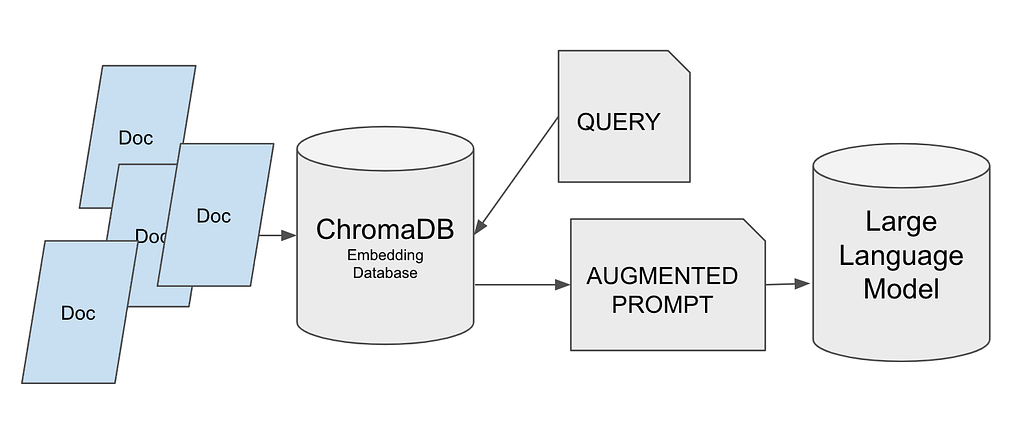

### Парсинг входных документов

создаем папку, куда положим документы

In [ ]:
mkdir data

In [ ]:
os.environ["OPENAI_API_KEY"] = ''


кодировщик текста, для кодирования текстов (для бд)

In [ ]:
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

In [ ]:
import uuid
from langchain.vectorstores import Chroma

# Уникальное имя для коллекции
unique_id = str(uuid.uuid4())
collection_name = f"{unique_id}_collection"

# Папка, куда будет сохраняться база
persist_directory = "./chroma_db"

# Создаем Chroma с сохранением на диск
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embeddings,
    persist_directory=persist_directory
)

vector_store.persist()

функция по разбиению и добавлению текстов в список

context_size=100 - размер блока текста, можно варьиировать его размер

In [ ]:
def add_context(chunks, context_size=100):
    contextual_chunks = []
    for i, chunk in enumerate(chunks):
        prev_chunk_content = chunks[i - 1].page_content[-context_size:] if i > 0 else ""
        next_chunk_content = chunks[i + 1].page_content[:context_size] if i < len(chunks) - 1 else ""
        contextual_chunk = Document(page_content=f"{prev_chunk_content}\n{chunk.page_content}\n{next_chunk_content}")
        contextual_chunks.append(contextual_chunk)
    return contextual_chunks

Загрузка и разбиение документов из директории

In [ ]:
def load_documents_from_directory(directory_path):
    all_chunks = []
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
            full_doc = loader.load()
            splitter = CharacterTextSplitter(
                separator=r"\n====КОНЕЦ СТРАНИЦЫ \d+====\n",
                is_separator_regex=True,
                keep_separator=True,
                chunk_overlap=0,
                chunk_size=0,
            )
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
            full_doc = loader.load()
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=1400,
                chunk_overlap=0,
                keep_separator=True
            )
        elif filename.endswith('.txt'):
            loader = TextLoader(file_path)
            full_doc = loader.load()
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=1400,
                chunk_overlap=0,
                keep_separator=True
            )
        else:
            print(f"Пропущен файл: {filename}")
            continue

        chunks = splitter.split_documents(full_doc)
        chunks_extended = add_context(chunks, context_size=600)
        all_chunks.extend(chunks_extended)
    return all_chunks

# 4. Обработка всех файлов в директории
directory_path = "/content/data"  # Укажите свою директорию
chunks = load_documents_from_directory(directory_path)

# 5. Индексация
uuids = [str(uuid.uuid4()) for _ in range(len(chunks))]
vector_store.add_documents(documents=chunks, ids=uuids)

Создаем ретривер для векторной БД chroma, а также поиск по ключевым словам BM25Retriever (похоже на TF-IDF) - их комбинация  в EnsembleRetriever позволяет достич лучшего поиска. Гиперпараметр weights=[0.5, 0.5] указывает на значимость ретриверов (настрока нужна)

In [ ]:
chroma_retriever = vector_store.as_retriever(search_kwargs={"k": 5})

bm25_retriever = BM25Retriever.from_documents(documents=chunks, k=5)

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5]
)

Посмотрим какой текст извлекается из бд (это наиболее близки куски текста к запросу пользователя)

In [ ]:
question=''
answer = ensemble_retriever.invoke(question)

Создадим вторую коллекцию - каталог - с информацией о товарах

In [ ]:
collection_name = f"catalog-collection"

# Папка, куда будет сохраняться база
persist_directory = "./chroma_db"

# Создаем Chroma с сохранением на диск
vector_store_catalog = Chroma(
    collection_name=collection_name,
    embedding_function=embeddings,
    persist_directory=persist_directory
)

vector_store_catalog.persist()

directory_path - папка, где храняться документы с каталогом

In [ ]:
directory_path = "/content/data_catalog"  # Укажите свою директорию
chunks = load_documents_from_directory(directory_path)

# 5. Индексация
uuids = [str(uuid.uuid4()) for _ in range(len(chunks))]
vector_store_catalog.add_documents(documents=chunks, ids=uuids)

Создаем ретривер для каталога

In [ ]:
chroma_retriever_catalog = vector_store_catalog.as_retriever(search_kwargs={"k": 5})

bm25_retriever_catalog = BM25Retriever.from_documents(documents=chunks, k=5)

ensemble_retriever_catalog = EnsembleRetriever(
    retrievers=[bm25_retriever_catalog, chroma_retriever_catalog], weights=[0.5, 0.5]
)

пример каталога

In [ ]:
catalog = [
  {
    "name": "Кольцо с бриллиантом",
    "description": "Элегантное кольцо с высококачественным бриллиантом 0.5 карата.",
    "usage": "Идеально подходит для особых случаев, таких как помолвка или свадьба.",
    "price": "15000 руб.",
    "url": "https://example.com/product/1"
  },
  {
    "name": "Серебряные серьги с аметистами",
    "description": "Серьги из 925 стерлингового серебра с аметистами высшей пробы.",
    "usage": "Подходят для ежедневного ношения или торжественных мероприятий.",
    "price": "8000 руб.",
    "url": "https://example.com/product/2"
  },
  {
    "name": "Золотая подвеска с изумрудом",
    "description": "Изысканная подвеска из 14-каратного золота с натуральным изумрудом.",
    "usage": "Отлично смотрится как для повседневного, так и для вечернего образа.",
    "price": "22000 руб.",
    "url": "https://example.com/product/3"
  },
  {
    "name": "Браслет с цирконами",
    "description": "Тонкий браслет с вставками из искусственных цирконов.",
    "usage": "Подходит для праздничных случаев или в качестве стильного аксессуара.",
    "price": "3500 руб.",
    "url": "https://example.com/product/4"
  },
  {
    "name": "Серьги с жемчугом",
    "description": "Классические серьги с натуральным жемчугом и золотыми вставками.",
    "usage": "Идеально для повседневного ношения или для элегантных мероприятий.",
    "price": "10000 руб.",
    "url": "https://example.com/product/5"
  },
  {
    "name": "Часы с бриллиантами",
    "description": "Шикарные часы с инкрустацией из бриллиантов на циферблате.",
    "usage": "Для людей, ценящих изысканный стиль и точность.",
    "price": "50000 руб.",
    "url": "https://example.com/product/6"
  },
  {
    "name": "Кулон с топазом",
    "description": "Изящный кулон с натуральным топазом, украшенный серебряной оправой.",
    "usage": "Можно носить как на праздники, так и для ежедневного стиля.",
    "price": "7000 руб.",
    "url": "https://example.com/product/7"
  },
  {
    "name": "Золотые обручальные кольца",
    "description": "Пара золотых обручальных колец с матовой отделкой и гравировкой.",
    "usage": "Идеально для жениха и невесты в день свадьбы.",
    "price": "25000 руб.",
    "url": "https://example.com/product/8"
  },
  {
    "name": "Печатка с ониксом",
    "description": "Мужская печатка с ониксом и серебряной оправой.",
    "usage": "Для стильных мужчин, предпочитающих выразительные аксессуары.",
    "price": "12000 руб.",
    "url": "https://example.com/product/9"
  },
  {
    "name": "Колье с сапфирами",
    "description": "Роскошное колье с натуральными сапфирами и бриллиантами.",
    "usage": "Для особых случаев, таких как вечеринки или торжественные мероприятия.",
    "price": "45000 руб.",
    "url": "https://example.com/product/10"
  }
]



Извлечение текста из двух коллекций

In [ ]:
question=''
products = ensemble_retriever_catalog.invoke(question)
context = ensemble_retriever.invoke(question)

### Запуск модели **Локально**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "IlyaGusev/saiga_llama3_8b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import LLMChain

# Пайплайн для генерации текста
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")  # Замените на нужный id
]

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
    eos_token_id=terminators,
)

# Создание LLM через HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

# Шаблон для формирования запроса
prompt_template = """
<|start_header_id|>user<|end_header_id|>
Ты — умный ассистент, специализирующийся на ювелирных украшениях.
Ваши основные задачи:
1. Отвечать на вопросы о ювелирных украшениях, их характеристиках и ценах по следующему контексту {context}
2. Помогать клиентам в выборе подходящих товаров по следующему контексту {products}

Ваша цель — предоставлять полезные, понятные и дружелюбные ответы.
Если вы не знаете ответа, просто скажите: «Я не знаю». Не придумывайте информацию.
При предложении товаров старайтесь быть конкретным и описывать, как товар может помочь.
Если для ответа требуется больше информации, задавайте уточняющие вопросы.

Вопрос: {question}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

# Создаем PromptTemplate
prompt = PromptTemplate(
    input_variables=["context", "products", "question"],
    template=prompt_template,
)

# Пример запроса пользователя
user_query = "Как выбрать кольцо с бриллиантом?"
products = ensemble_retriever_catalog.invoke(user_query)
context = ensemble_retriever.invoke(user_query)

# Создание LLMChain
llm_chain = LLMChain(
    llm=llm,
    prompt=prompt,
    output_parser=StrOutputParser()
)

# Создание словаря для передачи в цепочку
input_data = {
    "context": context,  # Передаем контекст
    "products": products,  # Передаем список товаров
    "question": user_query,  # Передаем сам запрос
}

# Запуск цепочки
response = llm_chain.run(input_data)
print(response)  # Выводим ответ


### Запуск модели с Open AI gpt-4o-mini

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import os

# Установка API-ключа OpenAI
os.environ['OPENAI_API_KEY'] = '<REMOVED>'



In [ ]:
from typing import Dict, Any
from langchain.chains import LLMChain
from langchain.schema import HumanMessage
from langchain.prompts import PromptTemplate

# Создание кастомной цепочки
class CustomRetrievalQA(LLMChain):
    def _call(self, inputs: Dict[str, Any]) -> Dict[str, Any]:
        context = inputs.get("context", "")
        products = inputs.get("products", "")
        query = inputs.get("query", "")

        # Формируем полный промпт
        full_prompt = self.prompt.format(context=context, products=products, query=query)

        # Преобразуем промпт в список сообщений
        messages = [HumanMessage(content=full_prompt)]

        # Вызываем модель с использованием метода invoke
        response = self.llm.invoke(messages)

        # Возвращаем результат с ключом 'text'
        return {"text": response.content}  # Используем response.content для получения текста



llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.5)

# Создание PromptTemplate
prompt_template = """
Ты — умный ассистент, специализирующийся на ювелирных украшениях.
Ваши основные задачи:
1. Отвечать на вопросы о ювелирных украшениях, их характеристиках и ценах по следующему контексту: {context}
2. Помогать клиентам в выборе подходящих товаров по следующему контексту: {products}

Ваша цель — предоставлять полезные, понятные и дружелюбные ответы.
Если вы не знаете ответа, просто скажите: «Я не знаю». Не придумывайте информацию.
При предложении товаров старайтесь быть конкретным и описывать, как товар может помочь.
Если для ответа требуется больше информации, задавайте уточняющие вопросы.

Вопрос: {query}
"""

prompt = PromptTemplate(
    input_variables=["context", "products", "query"],
    template=prompt_template
)

# Инициализация кастомной цепочки
custom_rag_chain = CustomRetrievalQA(
    llm=llm,
    prompt=prompt
)

In [ ]:
query = "Как ухаживать за украшениями?"

# Используем get_relevant_documents для извлечения документов
products = ensemble_retriever_catalog.invoke(user_query)
context = ensemble_retriever.invoke(user_query)

# Вызов кастомной цепочки
result = custom_rag_chain.invoke({
    "context": context,
    "query": query,
    "products": products
})

In [ ]:
print(result['text'])

In [ ]:
while True:
    query = input("Вы: ")  # Вводим сообщение пользователя
    if query.lower() in ["exit", "выход", "quit"]:  # Команда выхода
        break

    products = ensemble_retriever_catalog.invoke(user_query)
    context = ensemble_retriever.invoke(user_query)

    # Вызов кастомной цепочки
    result = custom_rag_chain.invoke({
        "context": context,
        "query": query,
        "products": products
    })

    print(result['text'])
    print(result['products'])

**Преимущества:**


**Управление метаданными:** Позволяет связывать вектора с дополнительными данными (например, текстами, контекстом), что делает её удобной для приложений NLP.

**Простота интеграции:** Простая установка и интеграция с популярными библиотеками, такими как LangChain.

**Легковесность:** Подходит для небольших и средних проектов, где нужно сочетание управления векторами и метаданными.

**Поддержка RAG:** Идеально подходит для работы с системами, где нужно извлечение данных на основе запросов.


**Недостатки:**


**Ограниченная производительность:** На больших наборах данных производительность уступает FAISS.

**Специализация:** ChromaDB лучше всего подходит для задач, связанных с RAG, и может быть менее универсальна для других сценариев.

### Повторное использование базы данных

In [ ]:
import chromadb

# Инициализация клиента с тем же путем для загрузки сохраненной базы данных
chroma_client_ = chromadb.PersistentClient(path="./chroma")

# Название коллекции, которую вы хотите загрузить
# collection_name = "catalog-collection"
collection_name = "support_collection"

# Получение списка имен коллекций
collection_names = chroma_client_.list_collections()

# Проверка, существует ли коллекция и загрузка ее
if collection_name in collection_names:
    collection = chroma_client_.get_collection(name=collection_name)
    print(f"Коллекция '{collection_name}' успешно загружена.")
else:
    print(f"Коллекция '{collection_name}' не найдена.")
    collection = None

In [ ]:
collection.get()

## Использование кэша

Используем collection определенную выше (коллекция с информацией по уходу)

In [ ]:
!pip install -q faiss-cpu==1.8.0

In [ ]:
import faiss
from sentence_transformers import SentenceTransformer
import time
import json

In [ ]:
def init_cache():
    index = faiss.IndexFlatL2(768)
    if index.is_trained:
        print("Index trained")

    # Sentence Transformer model
    encoder = SentenceTransformer("all-mpnet-base-v2")

    return index, encoder

In [ ]:
def retrieve_cache(json_file):
    try:
        with open(json_file, "r") as file:
            cache = json.load(file)
    except FileNotFoundError:
        cache = {"questions": [], "embeddings": [], "answers": [], "response_text": []}

    return cache

In [ ]:
def store_cache(json_file, cache):
    with open(json_file, "w") as file:
        json.dump(cache, file)

In [ ]:
class semantic_cache:
    def __init__(self, json_file="cache_file.json", collection = collection, thresold=0.35, max_response=100, eviction_policy=None):
        """Инициализируем семантический кэш.

        Args:
        json_file (str): Имя файла JSON, в котором хранится кэш.
        thresold (float): Пороговое значение евклидова расстояния для определения схожести вопросов.
        max_response (int): Максимальное количество ответов, которое может хранить кэш.
        eviction_policy (str): Политика вытеснения элементов из кэша.
                                Это может быть любая политика,например, 'FIFO' (First In First Out).
                                Если None, то политика выселения применяться не будет.
        """

        # Инициализация Faiss index with Euclidean distance
        self.index, self.encoder = init_cache()

        # Установите пороговое значение евклидова расстояния
        # расстояние, равное 0, означает, что предложения идентичны
        # Мы возвращаем только предложения из кэша ниже этого порогового значении
        self.euclidean_threshold = thresold
        self.collection = collection
        self.json_file = json_file
        self.cache = retrieve_cache(self.json_file)
        self.max_response = max_response
        self.eviction_policy = eviction_policy

    def evict(self):
        """Evicts an item from the cache based on the eviction policy."""
        if self.eviction_policy and len(self.cache["questions"]) > self.max_size:
            for _ in range((len(self.cache["questions"]) - self.max_response)):
                if self.eviction_policy == "FIFO":
                    self.cache["questions"].pop(0)
                    self.cache["embeddings"].pop(0)
                    self.cache["answers"].pop(0)
                    self.cache["response_text"].pop(0)

    def ask(self, question: str) -> str:

        start_time = time.time()
        try:
            embedding = self.encoder.encode([question])

            self.index.nprobe = 8
            D, I = self.index.search(embedding, 1)

            if D[0] >= 0:
                if I[0][0] >= 0 and D[0][0] <= self.euclidean_threshold:
                    row_id = int(I[0][0])

                    print("Answer recovered from Cache. ")
                    print(f"{D[0][0]:.3f} smaller than {self.euclidean_threshold}")
                    print(f"Found cache in row: {row_id} with score {D[0][0]:.3f}")
                    print(f"response_text: " + self.cache["response_text"][row_id])

                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    print(f"Time taken: {elapsed_time:.3f} seconds")
                    return self.cache["response_text"][row_id]


            answer = ensemble_retriever.invoke(question)
            response_text = answer["documents"][0][0]

            self.cache["questions"].append(question)
            self.cache["embeddings"].append(embedding[0].tolist())
            self.cache["answers"].append(answer)
            self.cache["response_text"].append(response_text)

            print("Answer recovered from ChromaDB. ")
            print(f"response_text: {response_text}")

            self.index.add(embedding)

            self.evict()

            store_cache(self.json_file, self.cache)

            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time taken: {elapsed_time:.3f} seconds")

            return response_text
        except Exception as e:
            raise RuntimeError(f"Error during 'ask' method: {e}")

In [ ]:
# Инициализация кэша
cache = semantic_cache("cache.json")

Получим наиболее близкие по смыслу тексты из базы данных . Важно - это не ответ модели! Данный код позволяет ускорить поиск в базе данных!

In [ ]:
results = cache.ask("Как ухаживать за серебром")

In [ ]:
results

Интеграция кэша с моделью

In [ ]:
class CustomRetrievalQA(LLMChain):
    def _call(self, inputs: Dict[str, Any]) -> Dict[str, Any]:
        context = inputs.get("context", "")
        products = inputs.get("products", "")
        query = inputs.get("query", "")

        # Формируем полный промпт
        full_prompt = self.prompt.format(context=context, products=products, query=query)

        # Преобразуем промпт в список сообщений
        messages = [HumanMessage(content=full_prompt)]

        # Вызываем модель с использованием метода invoke
        response = self.llm.invoke(messages)

        # Возвращаем результат с ключом 'text'
        return {"text": response.content}  # Используем response.content для получения текста


llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.5)

# Создание PromptTemplate
prompt_template = """
Ты — умный ассистент, специализирующийся на ювелирных украшениях.
Ваши основные задачи:
1. Отвечать на вопросы о ювелирных украшениях, их характеристиках и ценах по следующему контексту: {context}
2. Помогать клиентам в выборе подходящих товаров по следующему контексту: {products}

Ваша цель — предоставлять полезные, понятные и дружелюбные ответы.
Если вы не знаете ответа, просто скажите: «Я не знаю». Не придумывайте информацию.
При предложении товаров старайтесь быть конкретным и описывать, как товар может помочь.
Если для ответа требуется больше информации, задавайте уточняющие вопросы.

Вопрос: {query}
"""

prompt = PromptTemplate(
    input_variables=["context", "products", "query"],
    template=prompt_template
)

# Инициализация кастомной цепочки
custom_rag_chain = CustomRetrievalQA(
    llm=llm,
    prompt=prompt
)

In [ ]:
query = "Как ухаживать за украшениями?"

products = ensemble_retriever_catalog.invoke(query)
context = ensemble_retriever.invoke(query)

# Вызов кастомной цепочки
result = custom_rag_chain.invoke({
    "context": context,
    "query": query,
    "products": products
})

In [ ]:
print(result['text'])